# Data Processing: Preliminary 3D Line Confocal Microscope Scan Reconstruction

**Zoe Benaissa, Steven Diaz, Catherine Lange, Alexandra Otania, Amanda Powell, Therese Cook**

This program extracts the positions of 2μm-diameter fluorescent beads detected in our 3D Line Confocal Microscope's scan of an arbitrary row portion of a sample petri dish. The bead's point coordinates in (x, y, z) are outputted as arrays to be displayed in our Javascript visualizer program, where they will be offset by the physical distance the scans were taken between, 1000μm (1mm). This process is a preliminary demonstration of how a larger sample (such as a stenosis model) can be scanned by reconstructing smaller scan segments in post-processing.

**Credit:** The below code is modified from the starter code Javier and ChatGPT wrote. **Thank you!**

In [1]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

As the microscope camera vertically scans each "stack", it outputs the frames as individual tif files into the stack's unique directory.

Here, we define a utility function to combine these multiple tif files into one "multi-page"/layered tif file (to be compatible with the code Javier wrote). The file is saved into the stack's directory.

(Note: you don't need to call this function anywhere manually. It is used in the following step.)

In [2]:
def combine_frames(path):
    # Combines all the tif files in a folder into one multi-layered/"page" tif.
    # Takes as input the directory to the path, ie. "C:my_documents/data/scan/stack1"

    tif_files = []

    for filename in os.listdir(path):
        if filename.endswith(".tif"):
            tif_files.append(os.path.join(path, filename))

    # sanity check.
    # num_files = len(tif_filenames)
    # print(f"found {num_files} images under stack: {path}")

    # sort alphabetically to ensure proper ordering of frames
    tif_files.sort()

    # store the data here as a list
    data_list = []

    # combine! read data from each tif file and append to list
    for tif_file in tif_files:
        with tiff.TiffFile(tif_file) as tif:
            data_list.append(tif.asarray())

    # save
    combined_tif_output_path = f"{path}/combined.tif"
    tiff.imwrite(combined_tif_output_path, data_list)

The following is another utility function, which, provided the path to a stack directory, reads in the combined (multi-page/layer) tif file and returns it as a numpy array. If a combined tif file does not yet exist, it creates one before proceeding.

In [13]:
def stack_loader(path):
    # Load in and return the combined tif file as a numpy array.

    combined_tif_output_path = f"{path}/combined.tif"
    
    # If it doesn't exist yet, call the combine function & save the multi-
    # layered tif file.
    if not os.path.isfile(combined_tif_output_path):
        print("combined.tif wasn't found for this stack. writing now...")
        combine_frames(path)
    
    # read the multipage TIFF file
    with tiff.TiffFile(combined_tif_output_path) as tif:
        # Load all pages into a NumPy array
        stack_array = tif.asarray()
        print("stack loaded into numpy array.")
        print("it contains {} frames of dimensions {}x{} px.".format(*stack_array.shape))

    # return the array -- ready to be processed w/ Javier's code.
    return stack_array

Testing on first stack. (1/5 total)

In [14]:
stack1_array = stack_loader("D:/hella_data/beads120523/stack1")

stack loaded into numpy array.
it contains 100 frames of dimensions 920x2048 px.


Next, apply the extraction code Javier wrote to this stack. It scans the vertical stack frame-by-frame to find the brightest point locations (corresponding to the frame a point is in-focus). Note: it only handles the brightest point per-frame. It also avoids reporting duplicate points.

The average of all the frames are displayed, with these locations marked.

In [20]:
def get_point_locations(stack_array):
# Create a dictionary to store unique (x, y, z) coordinates of the brightest points and their associated intensities
  unique_brightest_points = {}
  # Create a list to store the intensity of the brightest point in each frame
  brightest_intensities = []

  # Define the minimum distance from the image boundaries for points to be retained
  min_distance = 21

  # Define the threshold for points to be considered duplicates in X and Y coordinates
  r = 10  # Adjust this threshold as needed

  # Iterate through the frames
  for frame_index in range(stack_array.shape[0]):
      frame = stack_array[frame_index]

      # Find the coordinates of the brightest point
      brightest_coord = np.unravel_index(np.argmax(frame), frame.shape)

      # Check if the point is too close to the image boundaries
      if (brightest_coord[0] <= min_distance or
          brightest_coord[0] >= frame.shape[0] - min_distance or
          brightest_coord[1] <= min_distance or
          brightest_coord[1] >= frame.shape[1] - min_distance):
          continue  # Skip points that are too close to the boundaries

      # Get the intensity of the brightest point
      brightest_intensity = frame[brightest_coord]

      # Check if there are nearby points within the threshold 'r'
      is_duplicate = False
      for existing_coord, existing_data in unique_brightest_points.items():
          if np.linalg.norm(np.array(brightest_coord[:2]) - np.array(existing_coord[:2])) <= r:
              is_duplicate = True
              # Check if the current intensity is higher than the existing one
              if brightest_intensity > existing_data[3]:
                  # Update the intensity if needed
                  unique_brightest_points[existing_coord] = (brightest_coord[0], brightest_coord[1], frame_index, brightest_intensity)
              break

      # If it's not a duplicate, add a new entry
      if not is_duplicate:
          unique_brightest_points[brightest_coord] = (brightest_coord[0], brightest_coord[1], frame_index, brightest_intensity)

      # Store the intensity in the list
      brightest_intensities.append(brightest_intensity)

  # Convert the dictionary values (tuples) back to a list
  unique_brightest_points_list = list(unique_brightest_points.values())

  # Extract X, Y, Z, and intensity coordinates for the plot
  x_coords, y_coords, z_coords, intensity_values = zip(*unique_brightest_points_list)

  # Create a scatter plot of the unique brightest points with intensities as text labels
  max_projection = np.max(stack_array, axis=0)

  # Create figure
  plt.figure(figsize=(10,6))

  # Plot with max projection to see the beads better
  plt.subplot(1, 2, 1)
  plt.imshow(np.log(max_projection))
  plt.title('Max projection of 3D stack, Log(I)')
  plt.xlabel('X Coordinate')
  plt.ylabel('Y Coordinate')
  plt.subplot(1, 2, 2)
  plt.imshow(np.log(max_projection))

  # Coordinates are flipped when displaying and image, so x=y and y=x
  plt.scatter(y_coords, x_coords, s=20, c='r', marker='o', label='Brightest Points')
  plt.xlabel('X Coordinate')
  plt.ylabel('Y Coordinate')
  plt.title('Location of Unique Brightest Points (Highest Intensity)')
  plt.legend()
  plt.grid(True)

  # Show the plot
  plt.show()

  # Print the (x, y, z, intensity) coordinates of the retained points
  for x, y, z, intensity in zip(x_coords, y_coords, z_coords, intensity_values):
      print(f"X: {x}, Y: {y}, Z (Frame): {z}, Intensity: {intensity}")

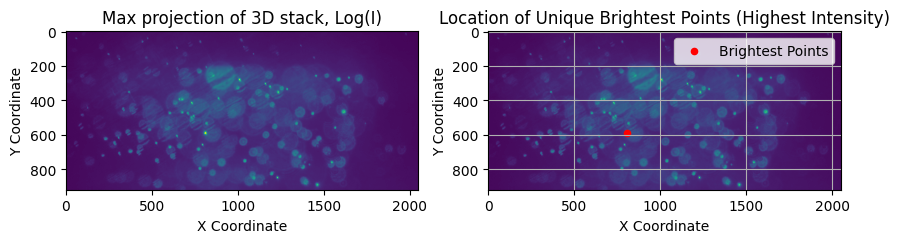

X: 590, Y: 808, Z (Frame): 0, Intensity: 65535.0


In [22]:
get_point_locations(stack1_array)

combined.tif wasn't found for this stack. writing now...
stack loaded into numpy array.
it contains 100 frames of dimensions 920x2048 px.


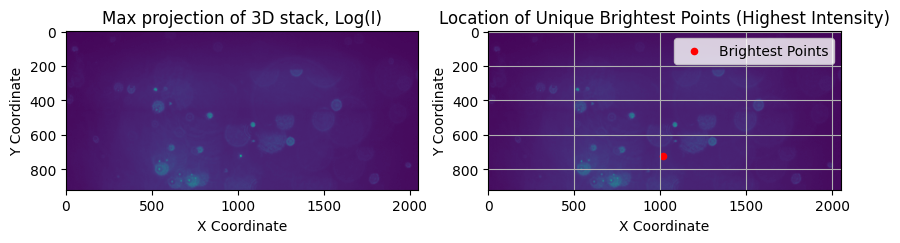

X: 724, Y: 1014, Z (Frame): 5, Intensity: 44868.0


In [23]:
stack2_array = stack_loader("D:/hella_data/beads120523/stack2")
get_point_locations(stack2_array)

combined.tif wasn't found for this stack. writing now...
stack loaded into numpy array.
it contains 100 frames of dimensions 920x2048 px.


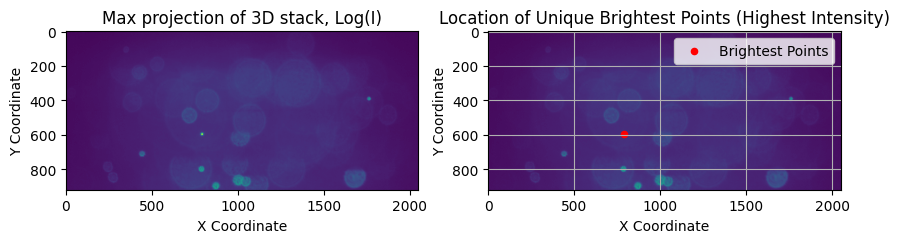

X: 598, Y: 788, Z (Frame): 17, Intensity: 11066.0


In [24]:
stack3_array = stack_loader("D:/hella_data/beads120523/stack3")
get_point_locations(stack3_array)

combined.tif wasn't found for this stack. writing now...
stack loaded into numpy array.
it contains 98 frames of dimensions 920x2048 px.


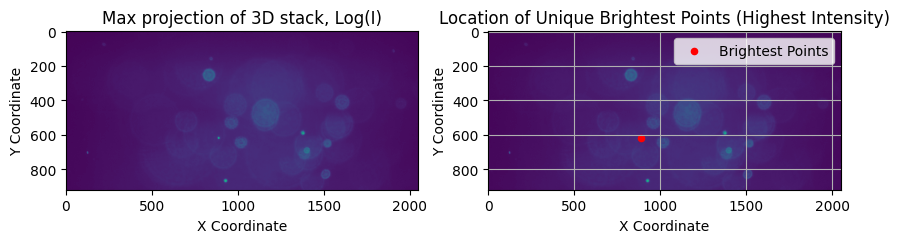

X: 619, Y: 886, Z (Frame): 39, Intensity: 58511.0


In [25]:
stack4_array = stack_loader("D:/hella_data/beads120523/stack4")
get_point_locations(stack4_array)

combined.tif wasn't found for this stack. writing now...
stack loaded into numpy array.
it contains 98 frames of dimensions 920x2048 px.


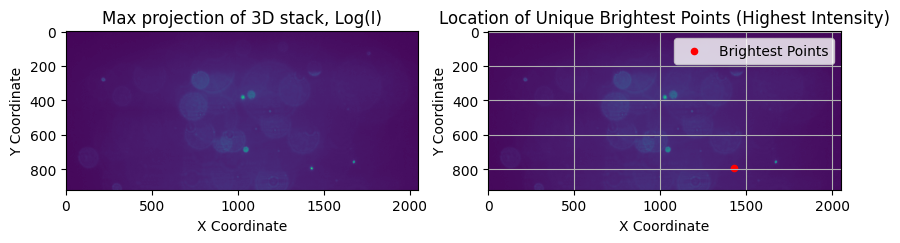

X: 795, Y: 1426, Z (Frame): 38, Intensity: 31941.0


In [26]:
stack5_array = stack_loader("D:/hella_data/beads120523/stack5")
get_point_locations(stack5_array)

Questions.

1. Visually- why are there so many more points present in the stack 1 frames compared to the 4 stacks?
Did the exposure get changed...? What exposure settings were used?
2. Why is only one point getting selected per stack? Should have at least been a few... wait. 
Maybe there's just one point that is way brighter than the other point for all the frames. AAAH! >:(
3. Are we seeing ANY overlap? :S

combined.tif wasn't found for this stack. writing now...
stack loaded into numpy array.
it contains 150 frames of dimensions 920x2048 px.


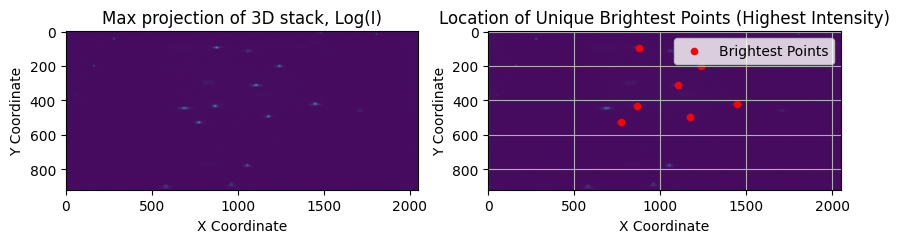

X: 312, Y: 1103, Z (Frame): 1, Intensity: 7619.0
X: 96, Y: 874, Z (Frame): 5, Intensity: 6543.0
X: 419, Y: 1446, Z (Frame): 62, Intensity: 4015.0
X: 202, Y: 1238, Z (Frame): 68, Intensity: 4488.0
X: 527, Y: 771, Z (Frame): 100, Intensity: 5525.0
X: 433, Y: 865, Z (Frame): 132, Intensity: 7089.0
X: 494, Y: 1171, Z (Frame): 118, Intensity: 739.0


In [27]:
new_array = stack_loader("D:/2um_Beads/Camera_0")
get_point_locations(new_array)

combined.tif wasn't found for this stack. writing now...
stack loaded into numpy array.
it contains 200 frames of dimensions 920x2048 px.


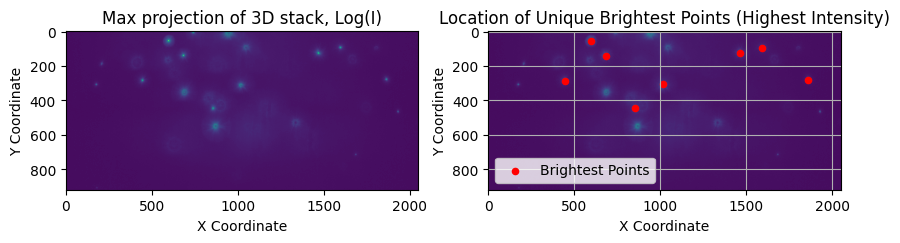

X: 55, Y: 596, Z (Frame): 181, Intensity: 9164.0
X: 95, Y: 1592, Z (Frame): 46, Intensity: 6255.0
X: 307, Y: 1016, Z (Frame): 64, Intensity: 932.0
X: 127, Y: 1464, Z (Frame): 94, Intensity: 10480.0
X: 446, Y: 852, Z (Frame): 72, Intensity: 1881.0
X: 285, Y: 443, Z (Frame): 108, Intensity: 6007.0
X: 141, Y: 681, Z (Frame): 141, Intensity: 10469.0
X: 279, Y: 1857, Z (Frame): 157, Intensity: 1519.0


In [28]:
s1_array = stack_loader("D:/final_scan_data/stack01/Camera_0")
get_point_locations(s1_array)

combined.tif wasn't found for this stack. writing now...
stack loaded into numpy array.
it contains 200 frames of dimensions 920x2048 px.


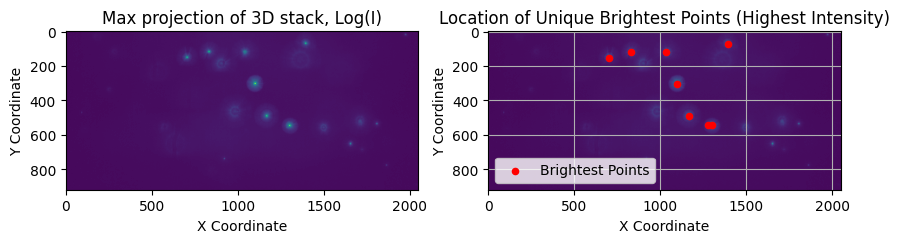

X: 546, Y: 1298, Z (Frame): 1, Intensity: 24287.0
X: 119, Y: 830, Z (Frame): 50, Intensity: 17085.0
X: 119, Y: 1033, Z (Frame): 75, Intensity: 1592.0
X: 543, Y: 1279, Z (Frame): 76, Intensity: 499.0
X: 70, Y: 1390, Z (Frame): 99, Intensity: 15277.0
X: 491, Y: 1164, Z (Frame): 82, Intensity: 10075.0
X: 151, Y: 702, Z (Frame): 109, Intensity: 9229.0
X: 303, Y: 1098, Z (Frame): 158, Intensity: 27402.0


In [29]:
s2_array = stack_loader("D:/final_scan_data/stack02/Camera_0")
get_point_locations(s2_array)

combined.tif wasn't found for this stack. writing now...
stack loaded into numpy array.
it contains 200 frames of dimensions 920x2048 px.


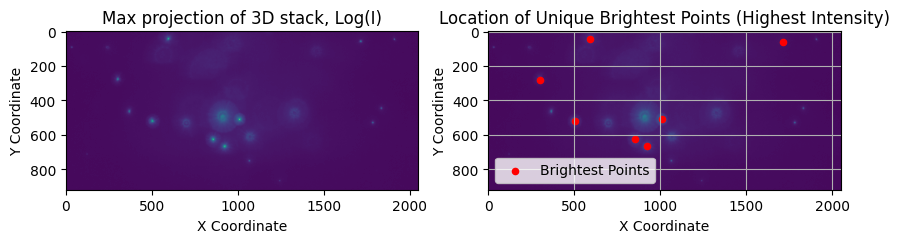

X: 520, Y: 501, Z (Frame): 4, Intensity: 10845.0
X: 626, Y: 854, Z (Frame): 15, Intensity: 23611.0
X: 60, Y: 1710, Z (Frame): 51, Intensity: 2884.0
X: 666, Y: 920, Z (Frame): 75, Intensity: 6480.0
X: 45, Y: 593, Z (Frame): 86, Intensity: 10634.0
X: 279, Y: 299, Z (Frame): 154, Intensity: 3064.0
X: 511, Y: 1007, Z (Frame): 187, Intensity: 28686.0


In [32]:
s3_array = stack_loader("D:/final_scan_data/stack03/Camera_0")
get_point_locations(s3_array)

combined.tif wasn't found for this stack. writing now...
stack loaded into numpy array.
it contains 200 frames of dimensions 920x2048 px.


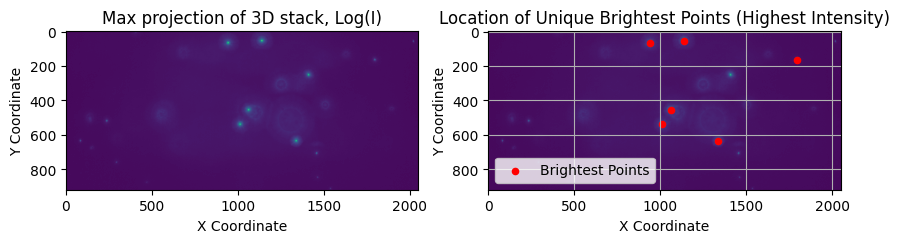

X: 455, Y: 1059, Z (Frame): 0, Intensity: 12102.0
X: 538, Y: 1010, Z (Frame): 16, Intensity: 25999.0
X: 68, Y: 940, Z (Frame): 51, Intensity: 25509.0
X: 165, Y: 1791, Z (Frame): 74, Intensity: 1656.0
X: 56, Y: 1136, Z (Frame): 91, Intensity: 22866.0
X: 635, Y: 1335, Z (Frame): 182, Intensity: 19570.0


In [33]:
s4_array = stack_loader("D:/final_scan_data/stack04/Camera_0")
get_point_locations(s4_array)

combined.tif wasn't found for this stack. writing now...
stack loaded into numpy array.
it contains 200 frames of dimensions 920x2048 px.


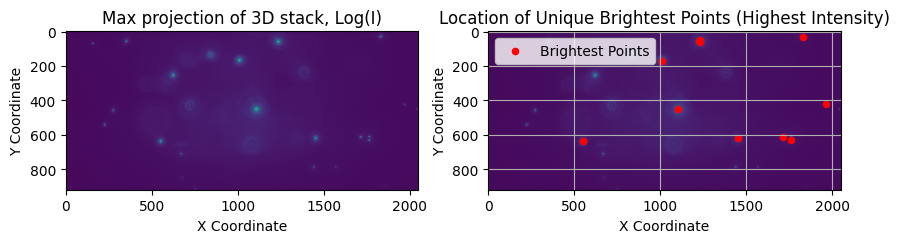

X: 169, Y: 1007, Z (Frame): 1, Intensity: 24058.0
X: 620, Y: 1448, Z (Frame): 15, Intensity: 10526.0
X: 631, Y: 1758, Z (Frame): 49, Intensity: 2377.0
X: 33, Y: 1826, Z (Frame): 60, Intensity: 2314.0
X: 613, Y: 1710, Z (Frame): 65, Intensity: 3336.0
X: 448, Y: 1102, Z (Frame): 70, Intensity: 3760.0
X: 61, Y: 1232, Z (Frame): 78, Intensity: 18699.0
X: 424, Y: 1964, Z (Frame): 129, Intensity: 685.0
X: 51, Y: 1232, Z (Frame): 130, Intensity: 635.0
X: 53, Y: 1222, Z (Frame): 134, Intensity: 587.0
X: 638, Y: 549, Z (Frame): 174, Intensity: 11400.0


In [34]:
s5_array = stack_loader("D:/final_scan_data/stack05/Camera_0")
get_point_locations(s5_array)

combined.tif wasn't found for this stack. writing now...
stack loaded into numpy array.
it contains 200 frames of dimensions 920x2048 px.


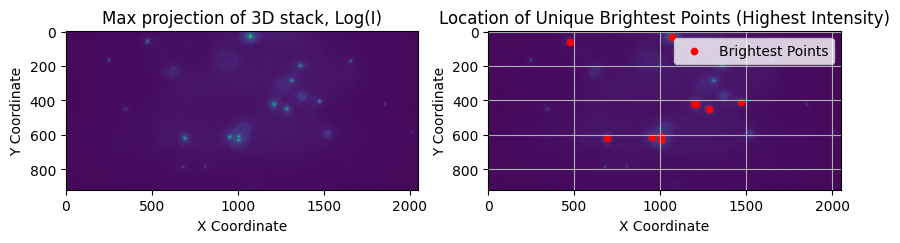

X: 619, Y: 690, Z (Frame): 21, Intensity: 19331.0
X: 450, Y: 1281, Z (Frame): 33, Intensity: 19118.0
X: 407, Y: 1470, Z (Frame): 40, Intensity: 9682.0
X: 631, Y: 1001, Z (Frame): 52, Intensity: 22512.0
X: 32, Y: 1069, Z (Frame): 62, Intensity: 34446.0
X: 613, Y: 952, Z (Frame): 68, Intensity: 24878.0
X: 610, Y: 1002, Z (Frame): 74, Intensity: 21331.0
X: 62, Y: 474, Z (Frame): 83, Intensity: 6161.0
X: 424, Y: 1207, Z (Frame): 123, Intensity: 23846.0
X: 419, Y: 1193, Z (Frame): 179, Intensity: 474.0


In [35]:
s6_array = stack_loader("D:/final_scan_data/stack06/Camera_0")
get_point_locations(s6_array)

combined.tif wasn't found for this stack. writing now...
stack loaded into numpy array.
it contains 200 frames of dimensions 920x2048 px.


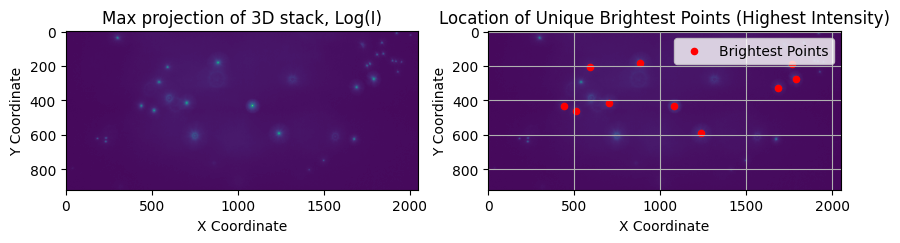

X: 432, Y: 1081, Z (Frame): 5, Intensity: 27314.0
X: 459, Y: 511, Z (Frame): 33, Intensity: 8569.0
X: 416, Y: 701, Z (Frame): 39, Intensity: 15180.0
X: 592, Y: 1236, Z (Frame): 54, Intensity: 19375.0
X: 182, Y: 882, Z (Frame): 67, Intensity: 19292.0
X: 208, Y: 590, Z (Frame): 75, Intensity: 6525.0
X: 189, Y: 1763, Z (Frame): 79, Intensity: 2020.0
X: 433, Y: 437, Z (Frame): 125, Intensity: 6327.0
X: 326, Y: 1686, Z (Frame): 147, Intensity: 4238.0
X: 278, Y: 1785, Z (Frame): 156, Intensity: 6683.0


In [36]:
s7_array = stack_loader("D:/final_scan_data/stack07/Camera_0")
get_point_locations(s7_array)

In [38]:
s8_array = stack_loader("D:/final_scan_data/stack08/Camera_0")
get_point_locations(s8_array)

combined.tif wasn't found for this stack. writing now...


MemoryError: Unable to allocate 2.81 GiB for an array with shape (200, 920, 2048) and data type float64

In [ ]:
s9_array = stack_loader("D:/final_scan_data/stack09/Camera_0")
get_point_locations(s9_array)

In [ ]:
s10_array = stack_loader("D:/final_scan_data/stack10/Camera_0")
get_point_locations(s10_array)

In [ ]:
s11_array = stack_loader("D:/final_scan_data/stack11/Camera_0")
get_point_locations(s11_array)